## Mini-Project
### Road Sign Detection 

In [ ]:
# yolo8 라이브러리 설치 확인하기
!pip install ultralytics
!pip install opencv-python
!pip install matplotlib

### 1. 데이터 준비하기
### 1-1. Pascal VOC Format to YOLO Format

In [27]:
import xml.etree.ElementTree as ET
import glob
import locale
import os
import json
from tqdm import tqdm
from ultralytics import YOLO
from google.colab import drive
import subprocess

drive.mount('/content/drive')

os.getcwd()
locale.getpreferredencoding = lambda: "UTF-8"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
gpu_info = subprocess.check_output(["nvidia-smi"]).decode("utf-8")

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug 23 15:03:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
!unzip -qq "/content/drive/MyDrive/Colab_Notebooks/data/road_sign.zip"

In [8]:
# Pascal VOC Format to YOLO Format
def xml_to_yolo_bbox(bbox, w, h):
    # Bounding box info
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return (x_center, y_center, width, height)


In [9]:
road_sign_root = "/content/"
annot_path = os.path.join(road_sign_root,"annotations")
img_path = os.path.join(road_sign_root,"images")
label_path = os.path.join(road_sign_root,"labels")

if not os.path.exists(label_path):
    os.makedirs(label_path)

In [10]:
# Convert Pascal VOC Format label to YOLO Format label
classes = []

# Load "*.xml" file list
files = glob.glob(os.path.join(annot_path, "*.xml"))
for fil in tqdm(files):
  # Use Tag Name
  basename = os.path.basename(fil)
  filename = os.path.splitext(basename)[0]          # 'road0, road1, ...

  result = []

  tree = ET.parse(fil)
  root = tree.getroot()                                 # <annotation> ~ </annotation>

  width = int(root.find("size").find("width").text)     # 300
  height = int(root.find("size").find("height").text)   # 400
  #print(width, height)

  for obj in root.findall('object'):
    label = obj.find("name").text
    if label not in classes:
      classes.append(label)

    index = classes.index(label)
    bbox = [int(x.text) for x in obj.find("bndbox")]    # [xmin, ymin, xmax, ymax]
    # print(bbox)

    # Normalize BBox info
    yolo_bbox = xml_to_yolo_bbox(bbox, width, height)   # [x_center, y_center, width, height]
    bbox_string = " ".join([str(x) for x in yolo_bbox])
    result.append(f"{index} {bbox_string}")
    if result:
        with open(os.path.join(label_path, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

100%|██████████| 877/877 [00:00<00:00, 5283.06it/s]


### 1-2. 데이터 전처리하기

In [11]:
cd '/content'

/content


In [12]:
import os
import random
from shutil import copyfile, rmtree

road_sign_path = "/content"
label_ = '.txt'
img_ = '.png'

# 저장 경로 만들기
folder_list = ['road_sign_detection/train', 'road_sign_detection/val', 'road_sign_detection/train/images', \
                'road_sign_detection/train/labels', 'road_sign_detection/val/images', 'road_sign_detection/val/labels']
for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [13]:
file_list = os.listdir(os.path.join(road_sign_path, 'images'))
#print(len(file_list))

## 1. Shuffle
random.shuffle(file_list)

## 2. Split Train/Test
test_ratio = 0.1
test_list = file_list[:int(len(file_list)*test_ratio)]
train_list = file_list[int(len(file_list)*test_ratio):]

print(f"train의 개수 : {len(train_list)}, test의 개수 : {len(test_list)}")

## 3. move the Files to Train/Val directory
for i in test_list:
  f_name = os.path.splitext(i)[0]
  copyfile(os.path.join(road_sign_path, 'images', (f_name+img_)), os.path.join(road_sign_path, 'road_sign_detection/val/images', (f_name+img_)))
  copyfile(os.path.join(road_sign_path, 'labels', (f_name+label_)), os.path.join(road_sign_path, 'road_sign_detection/val/labels', (f_name+label_)))
for i in train_list:
  f_name = os.path.splitext(i)[0]
  copyfile(os.path.join(road_sign_path, 'images', (f_name+img_)), os.path.join(road_sign_path, 'road_sign_detection/train/images', (f_name+img_)))
  copyfile(os.path.join(road_sign_path, 'labels', (f_name+label_)), os.path.join(road_sign_path, 'road_sign_detection/train/labels', (f_name+label_)))

train의 개수 : 790, test의 개수 : 87


In [14]:
train_images = os.listdir('/content/road_sign_detection/train/images')
train_labels = os.listdir('/content/road_sign_detection/train/labels')
val_images = os.listdir('/content/road_sign_detection/val/images')
val_labels = os.listdir('/content/road_sign_detection/val/labels')

print(len(train_images), len(train_labels))
print(len(val_images), len(val_labels))

790 790
87 87


### 1-3. Config file(.yaml) 만들기

In [16]:
cd '/content/project_road_sign_detection'

/content/project_road_sign_detection


In [17]:
import yaml
data =dict()

data['train'] = '/content/road_sign_detection/train'
data['val'] = '/content/road_sign_detection/val'
data['test'] = '/content/road_sign_detection/val'

data['nc'] = 4
data['names'] =['Trafic_light','Speedlimit', 'Crosswalk','Stop']

with open('road_sign.yaml', 'w') as f:
	yaml.dump(data, f)

### 2. Training

In [18]:
cd '/content/project_road_sign_detection'

/content/project_road_sign_detection


In [41]:
from ultralytics import YOLO
model = YOLO('yolov8s.yaml')
results = model.train(data ='road_sign.yaml', epochs = 100, batch=32, device = 0, patience=30, name='road_sign_s')

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=road_sign.yaml, epochs=100, time=None, patience=30, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=road_sign_s2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning /content/road_sign_detection/train/labels.cache... 790 images, 0 backgrounds, 0 corrupt: 100%|██████████| 790/790 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/road_sign_detection/val/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]


Plotting labels to runs/detect/road_sign_s2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/road_sign_s2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       8.3G      3.723      5.379       4.33         65        640: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         87        124   0.000242      0.126    0.00018   5.29e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.98G      3.243      4.356      3.861         63        640: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         87        124    0.00024     0.0422   0.000202   5.18e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.97G      2.606      3.454      3.204         58        640: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         87        124   0.000418      0.126   0.000465   0.000127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.04G      2.207      2.679      2.622         68        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         87        124    0.00101      0.192     0.0223     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.96G      1.893       2.14      2.285         61        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         87        124      0.941      0.201      0.283      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.04G      1.645      1.712      2.019         53        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         87        124      0.784      0.378      0.468      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.99G      1.541       1.53      1.917         46        640: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         87        124      0.648      0.523      0.472      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.04G      1.454      1.452      1.801         51        640: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         87        124      0.948      0.528      0.593      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.06G      1.309      1.295      1.718         68        640: 100%|██████████| 25/25 [00:16<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         87        124      0.732       0.61      0.568      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.04G      1.219      1.235      1.634         54        640: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         87        124      0.876      0.523      0.597      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.99G       1.14      1.113      1.535         58        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         87        124       0.85      0.578       0.63      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.04G      1.112      1.046      1.481         74        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         87        124      0.661      0.624      0.625      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.06G       1.06     0.9832      1.447         52        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         87        124      0.959       0.59      0.669      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.09G      1.056      1.015      1.443         48        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         87        124      0.752      0.598      0.673      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         8G      1.032     0.9373      1.397         71        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         87        124      0.853      0.655      0.693      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.04G     0.9864     0.8839      1.329         54        640: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         87        124      0.863      0.613      0.722      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         8G     0.9529     0.8389      1.323         51        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         87        124      0.793      0.711      0.757      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.04G     0.9324     0.8191      1.315         52        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         87        124      0.741      0.666      0.722      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.99G     0.9856     0.8434      1.332         46        640: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         87        124      0.943      0.607       0.71      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.03G     0.9099     0.7842      1.293         63        640: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         87        124      0.901      0.695      0.809        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.96G     0.9375     0.7854      1.304         60        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         87        124       0.84      0.661      0.736      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.04G     0.8917      0.749       1.25         62        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         87        124      0.768      0.686      0.752      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         8G     0.8774     0.7572      1.254         46        640: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         87        124      0.678      0.726      0.721      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.04G      0.853     0.7098      1.227         74        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         87        124      0.801       0.73      0.808      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.01G      0.897     0.7426      1.293         53        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         87        124      0.843      0.737      0.811      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.04G     0.8558     0.6832      1.225         66        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         87        124       0.88      0.708      0.789      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.02G     0.8232     0.6655      1.209         48        640: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         87        124      0.789      0.626      0.721      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.04G     0.8405     0.6589      1.224         61        640: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         87        124      0.717      0.776      0.807      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.99G     0.8099     0.6443      1.183         57        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         87        124      0.832        0.7       0.77      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.03G     0.8198     0.6457      1.179         51        640: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         87        124      0.901      0.738      0.842      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.96G     0.7793     0.6227      1.176         48        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         87        124      0.858      0.724      0.793       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.04G     0.8219     0.6444      1.192         48        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         87        124      0.817      0.812      0.825       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.96G     0.7939      0.615      1.173         54        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         87        124      0.903      0.799      0.828      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.08G      0.781     0.5981      1.154         59        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         87        124      0.736      0.813      0.749      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.96G     0.7816     0.6116      1.161         62        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         87        124      0.814      0.692      0.765      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.04G     0.7859     0.6095      1.165         68        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         87        124      0.856      0.816      0.861      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.96G     0.7837     0.6022      1.162         48        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         87        124      0.877      0.863      0.889      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.04G     0.7672     0.6018      1.167         50        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         87        124      0.813      0.792      0.795      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.99G     0.7371      0.553      1.116         71        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         87        124      0.819      0.886      0.865       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.03G      0.748     0.5653      1.133         46        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         87        124      0.868        0.8      0.866      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         8G     0.7664     0.5619       1.14         53        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         87        124      0.817      0.841      0.843      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.04G     0.7241      0.557      1.126         59        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         87        124      0.743      0.881      0.809      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.96G     0.7341      0.537      1.102         54        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         87        124      0.746      0.843      0.829      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.07G     0.7366     0.5408      1.113         59        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all         87        124      0.915      0.835      0.883       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.01G     0.7297     0.5361      1.111         51        640: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         87        124      0.849      0.866      0.871      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.08G     0.7199     0.5156      1.111         56        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

                   all         87        124       0.91      0.841      0.888      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.96G     0.7002     0.5164      1.105         77        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         87        124      0.794      0.893      0.844      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.04G     0.7214     0.5188      1.097         59        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         87        124      0.947      0.914      0.913      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.99G     0.6802     0.4997      1.071         57        640: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         87        124      0.949      0.806      0.902      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.04G     0.7006     0.5064      1.092         58        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         87        124      0.867      0.839      0.872      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.96G     0.7017     0.5065      1.095         61        640: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         87        124      0.912      0.829      0.873      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.08G     0.7114     0.4988      1.097         46        640: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         87        124      0.858       0.89      0.877      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.99G     0.6922     0.4905      1.079         47        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         87        124      0.875      0.805      0.861      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.03G     0.7008     0.5132      1.093         49        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         87        124      0.883      0.881      0.901      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         8G      0.691     0.4891      1.081         60        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         87        124      0.857      0.805      0.843      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.04G     0.7041      0.485      1.062         54        640: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         87        124      0.858      0.889      0.884       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.96G     0.6848     0.4889      1.078         61        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         87        124      0.893      0.902      0.908      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.03G     0.6671     0.4649      1.076         56        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         87        124      0.953      0.855       0.92      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.05G     0.6781     0.4736      1.065         53        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         87        124      0.921      0.843      0.896      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.03G       0.66      0.462      1.062         58        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         87        124      0.932      0.895      0.907       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.97G     0.6503     0.4588      1.059         43        640: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         87        124      0.873       0.92      0.904      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.04G     0.6608     0.4532      1.062         57        640: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         87        124        0.9      0.907      0.905      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.96G     0.6464     0.4456       1.04         57        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all         87        124      0.907      0.858      0.898      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.04G     0.6511      0.456      1.053         51        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         87        124      0.924      0.888      0.907      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         8G     0.6435     0.4382      1.039         59        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         87        124       0.93      0.915      0.916      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.04G     0.6401     0.4301      1.032         60        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         87        124      0.914      0.916      0.905      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.97G     0.6588      0.445      1.063         63        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         87        124      0.912      0.876      0.899      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.04G     0.6352      0.445      1.034         63        640: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         87        124      0.921      0.875      0.912      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.97G     0.6277      0.432      1.044         60        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         87        124      0.856      0.881      0.893      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.04G      0.636     0.4425      1.061         58        640: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         87        124      0.867      0.909      0.903      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         8G     0.6241     0.4233      1.035         59        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         87        124      0.919      0.864      0.912      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.04G     0.6153     0.4175      1.024         48        640: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         87        124        0.9      0.897      0.889      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         8G     0.6208     0.4213      1.015         50        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         87        124      0.917       0.88      0.908      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.04G     0.6066     0.4111      1.033         63        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         87        124      0.939      0.877      0.911      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.96G     0.6261     0.4178      1.021         54        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         87        124       0.88      0.903      0.904      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.04G     0.6125     0.4099      1.013         46        640: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         87        124      0.922      0.869      0.906      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         8G     0.5883     0.4027      1.019         59        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         87        124      0.969      0.905      0.944      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.04G     0.5936     0.3938      1.002         52        640: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all         87        124      0.964      0.896      0.925      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.99G     0.5951     0.4009      1.006         71        640: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]

                   all         87        124      0.935      0.889      0.918      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.04G     0.6016     0.4051       1.02         46        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         87        124      0.919       0.89      0.903      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.96G     0.5889     0.3858      1.009         51        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         87        124       0.93      0.907      0.919      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.04G     0.5995     0.4022      1.029         60        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         87        124      0.967      0.879      0.932      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.96G      0.578     0.3844      1.004         57        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         87        124      0.912      0.936      0.937      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.08G     0.5861     0.3951      1.004         53        640: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         87        124      0.949      0.895      0.926      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.96G     0.5774     0.3803      1.006         57        640: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         87        124      0.921      0.919      0.924      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.04G     0.5846     0.3825     0.9981         46        640: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         87        124      0.945      0.917      0.929       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         8G      0.579     0.3796     0.9939         55        640: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         87        124      0.944      0.884       0.92      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.04G     0.5593     0.3709     0.9925         54        640: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         87        124      0.954      0.918       0.93      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.96G     0.5554     0.3704     0.9972         46        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         87        124      0.947      0.918      0.925      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.04G     0.5578     0.3778          1         57        640: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         87        124      0.945      0.901      0.938      0.768


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.96G     0.5201     0.3374     0.9647         28        640: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         87        124      0.937      0.901      0.928      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.04G     0.5246     0.3257     0.9569         39        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         87        124      0.984      0.916      0.943      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.96G     0.5078     0.3238      0.958         38        640: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         87        124      0.957      0.921       0.94      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.04G      0.503     0.3098     0.9484         31        640: 100%|██████████| 25/25 [00:17<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]

                   all         87        124      0.969      0.901      0.925      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.96G     0.4911     0.3033     0.9431         36        640: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         87        124      0.949      0.914      0.929      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.04G     0.5094     0.3125     0.9518         37        640: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         87        124      0.958      0.917      0.931      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.96G     0.4947     0.3079     0.9432         32        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         87        124      0.934      0.917      0.931      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.04G      0.498     0.2994     0.9441         32        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         87        124      0.945      0.924      0.931      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.96G     0.4828     0.2996     0.9434         28        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         87        124      0.971      0.914       0.93      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.04G     0.4988     0.3065     0.9292         32        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         87        124      0.958      0.917      0.929      0.791



100 epochs completed in 0.654 hours.
Optimizer stripped from runs/detect/road_sign_s2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/road_sign_s2/weights/best.pt, 22.5MB

Validating runs/detect/road_sign_s2/weights/best.pt...
Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


                   all         87        124      0.958      0.917      0.929      0.791
          Trafic_light         69         82      0.986      0.988      0.986       0.92
            Speedlimit         11         11      0.976          1      0.995       0.85
             Crosswalk          9          9      0.993          1      0.995      0.833
                  Stop         13         22      0.877      0.682      0.742      0.561
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/road_sign_s2


In [42]:
import shutil
import zipfile
import os
from google.colab import files

# 압축할 디렉토리와 압축 파일 경로 설정
directory_to_zip = '/content/runs/detect/road_sign_s2'
output_filename = '/content/NO_TensorRT_YOLO_v8n.zip'

# 디렉토리를 압축
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# 압축된 파일 다운로드
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3. Testing (Validation)

In [19]:
cd '/content/project_road_sign_detection'

/content/project_road_sign_detection


In [29]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 34.4/78.2 GB disk)


In [20]:
# 1. import library
from ultralytics import YOLO

# 2. Load a model
model_path = "/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.pt"
model = YOLO(model_path)  # load a custom model

# 3. Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

print("map50-95", metrics.box.map)
print("map50", metrics.box.map50)

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 21.0MB/s]
val: Scanning /content/road_sign_detection/val/labels... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 871.77it/s]

val: New cache created: /content/road_sign_detection/val/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


                   all         87        120     0.0177     0.0826     0.0107    0.00905
          Trafic_light         66         76    0.00685     0.0132    0.00355    0.00319
            Speedlimit         20         23     0.0417      0.217     0.0266     0.0205
             Crosswalk         11         11          0          0          0          0
                  Stop          8         10     0.0222        0.1     0.0125     0.0125
Speed: 7.2ms preprocess, 15.1ms inference, 0.0ms loss, 20.3ms postprocess per image
Results saved to runs/detect/val
map50-95 0.00905250439583548
map50 0.010668288527397261


In [22]:
import shutil
import zipfile
import os
from google.colab import files

# 압축할 디렉토리와 압축 파일 경로 설정
directory_to_zip = '/content/project_road_sign_detection/runs/detect/val'
output_filename = '/content/Validated_by_YOLO_v8n_with_NO_TensorRT.zip'

# 디렉토리를 압축
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# 압축된 파일 다운로드
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 4. Inference

In [43]:
cd '/content/project_road_sign_detection'

/content/project_road_sign_detection


In [44]:
from ultralytics import YOLO
import cv2
import os
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
import numpy as np

model_path = "/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.pt"
model = YOLO(model_path)

root_folder = 'test'
result_folder = 'result'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

test_img_list = os.listdir(root_folder)

device = 'cpu'
color_dict = [(0, 255, 0),(255, 255, 0),(0, 0, 255), (255, 0,0)]
color_dict_2 = [(0, 0, 0),(0, 0, 0),(255, 255, 255), (255, 255,255)]

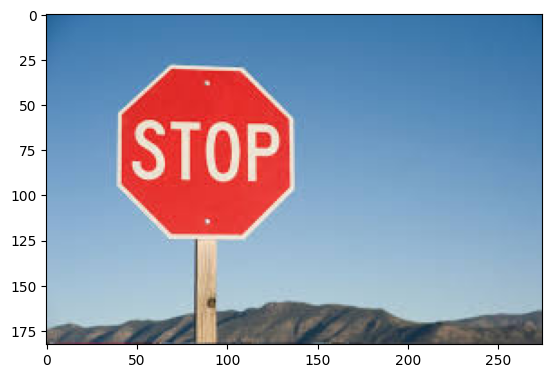


0: 448x640 1 Stop, 15.8ms
Speed: 4.6ms preprocess, 15.8ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Trafic_light', 1: 'Speedlimit', 2: 'Crosswalk', 3: 'Stop'}
obb: None
orig_img: array([[[149,  98,  36],
        [150,  99,  37],
        [151, 100,  38],
        ...,
        [153, 102,  40],
        [153, 102,  40],
        [153, 102,  40]],

       [[150,  99,  37],
        [151, 100,  38],
        [152, 101,  39],
        ...,
        [154, 103,  41],
        [154, 103,  41],
        [153, 102,  40]],

       [[151, 100,  38],
        [152, 101,  39],
        [153, 102,  40],
        ...,
        [155, 104,  42],
        [155, 104,  42],
        [155, 104,  42]],

       ...,

       [[109, 113, 118],
        [ 92,  95,  99],
        [ 89,  91,  92],
        ...,
        [ 75,  77,  78],
        [ 75,  77,  78],
   

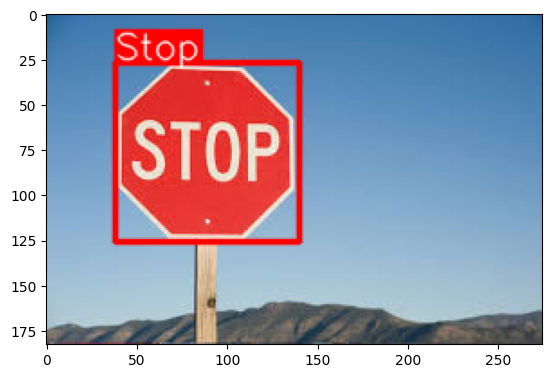

In [49]:
# Write down Inference cod of detecing road sign
# 1. Read Image
test_img = cv2.imread(os.path.join(root_folder, test_img_list[0]))
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_src)
plt.show()

# 2. Inference
results = model(test_img)
print(results)
for result in results:
    annotator = Annotator(img_src)
    boxes = result.boxes
    for box in boxes:
      b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
      # print(b)
      cls = box.cls
      annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])

# 3. Visualization
img_src = annotator.result()
plt.imshow(img_src)
plt.show()


In [48]:
for idx , file in enumerate(test_img_list):
    test_img = cv2.imread(os.path.join(root_folder, file))
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    print(img_src.shape)
    print('------------------------------')
    results = model(test_img)

    for result in results:
        annotator = Annotator(img_src)
        boxes = result.boxes
        for box in boxes:
            b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
            cls = box.cls
            annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)],color_dict_2[int(cls)])
    img_src = annotator.result()
    img_src = cv2.resize(img_src, (400,400))
    cv2.imwrite(os.path.join(result_folder, file), cv2.cvtColor(img_src, cv2.COLOR_RGB2BGR))

(183, 275, 3)
------------------------------

0: 448x640 1 Stop, 22.6ms
Speed: 2.6ms preprocess, 22.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)
(194, 259, 3)
------------------------------

0: 480x640 2 Trafic_lights, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)
(177, 284, 3)
------------------------------

0: 416x640 (no detections), 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


### 5. TensorRT 변환
### 5-1. Export

In [50]:
cd /content/project_road_sign_detection

/content/project_road_sign_detection


In [51]:
from ultralytics import YOLO

* engine 생성 후에 `best_fp32.engine`로 변경하기

In [54]:
model_path = "/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.pt"
model = YOLO(model_path)
model.export(format='engine', device=0, half=False)

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (21.5 MB)

ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 1.3s, saved as '/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.onnx' (42.7 MB)

TensorRT: starting export with TensorRT 10.3.0...
TensorRT: input "images" with shape(1, 3, 640, 640) DataType.FLOAT
TensorRT: output "output0" with shape(1, 8, 8400) DataType.FLOAT
TensorRT: building FP32 engine as /content/drive/MyDrive/Colab_Notebooks/road_sign_detection.engine
TensorRT: export success ✅ 80.8s, saved as '/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.engine' (53.7 MB)

Export complete (81.1s)
Results saved to /content/drive/MyDrive/Colab_Notebooks/FastCam

'/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.engine'

* engine 생성 후에 `best_fp16.engine`로 변경하기

In [53]:
model_path = "/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.pt"
model = YOLO(model_path)
model.export(format='engine', device=0, half=True)

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (21.5 MB)

ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 1.2s, saved as '/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.onnx' (42.7 MB)

TensorRT: starting export with TensorRT 10.3.0...
TensorRT: input "images" with shape(1, 3, 640, 640) DataType.FLOAT
TensorRT: output "output0" with shape(1, 8, 8400) DataType.FLOAT
TensorRT: building FP16 engine as /content/drive/MyDrive/Colab_Notebooks/road_sign_detection.engine
TensorRT: export success ✅ 321.9s, saved as '/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.engine' (23.3 MB)

Export complete (322.2s)
Results saved to /content/drive/MyDrive/Colab_Notebooks/FastC

'/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.engine'

### 5-2. 결과 비교하기

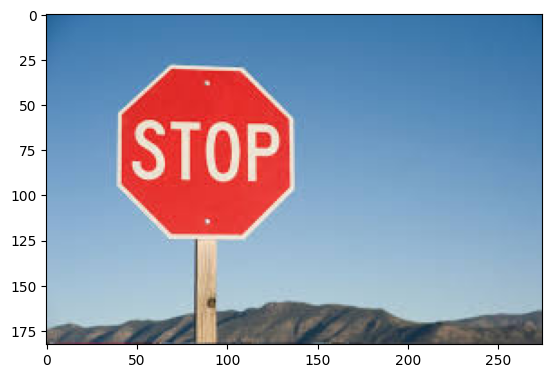

In [56]:
from ultralytics import YOLO
import cv2
import os

root_folder = 'test'
test_img_list = os.listdir(root_folder)

test_img = cv2.imread(os.path.join(root_folder, test_img_list[0]))
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(img_src)
plt.show()

In [57]:
# torch
model_path = "/content/drive/MyDrive/Colab_Notebooks/road_sign_detection.pt"
model = YOLO(model_path)
results = model.val(data="road_sign.yaml", batch=1, imgsz=640, plots=False, device=0, half=False, verbose=False)
metric, speed = results.results_dict['metrics/mAP50-95(B)'], results.speed['inference']
print(metric, speed)

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/road_sign_detection/val/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 87/87 [00:04<00:00, 21.12it/s]

                   all         87        120     0.0177     0.0826     0.0106    0.00917
Speed: 0.4ms preprocess, 33.4ms inference, 0.0ms loss, 2.3ms postprocess per image
0.009166205552959845 33.371404669750696


In [58]:
#float 16
model_fp16_path = "/content/drive/MyDrive/Colab_Notebooks/best_fp16.engine"
model = YOLO(model_fp16_path)
results = model.val(data="road_sign.yaml", batch=1, imgsz=640, plots=False, device=0, half=True, verbose=False)
metric, speed = results.results_dict['metrics/mAP50-95(B)'], results.speed['inference']
print(metric, speed)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Loading /content/drive/MyDrive/Colab_Notebooks/best_fp16.engine for TensorRT inference...


val: Scanning /content/road_sign_detection/val/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 87/87 [00:01<00:00, 65.61it/s]


                   all         87        120     0.0138     0.0718    0.00846    0.00732
Speed: 0.7ms preprocess, 5.7ms inference, 0.0ms loss, 2.0ms postprocess per image
0.007318817797021938 5.723964208844064


In [59]:
#float 32
model_fp32_path = "/content/drive/MyDrive/Colab_Notebooks/best_fp32.engine"
model = YOLO(model_fp32_path)
results = model.val(data="road_sign.yaml", batch=1, imgsz=640, plots=False, device=0, half=False, verbose=False)
metric, speed = results.results_dict['metrics/mAP50-95(B)'], results.speed['inference']
print(metric, speed)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Loading /content/drive/MyDrive/Colab_Notebooks/best_fp32.engine for TensorRT inference...


val: Scanning /content/road_sign_detection/val/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 87/87 [00:02<00:00, 42.22it/s]

                   all         87        120      0.014     0.0718    0.00857    0.00729
Speed: 0.6ms preprocess, 11.1ms inference, 0.0ms loss, 2.1ms postprocess per image
0.0072935071477921495 11.08480321949926
